# Imports

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import math
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# change to this notebook's directory
!ls '/content/drive/My Drive/UVic/Synthesizer Programming'
path = '/content/drive/My Drive/UVic/Synthesizer Programming/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2001_alto.csv		 Assignment1.ipynb	fm_synthesis.ipynb
2001_bass.csv		 Assignment2.ipynb	GlassMug.wav
2001_melody.csv		 Assignment3.ipynb	modal_synthesis.ipynb
2001_tenor.csv		 Assignment4.ipynb	water_drop.wav
2001_treble.csv		 CeramicMug.wav
additive_synthcsp.ipynb  digital_filters.ipynb


# Q3

In [3]:
sr = 44100

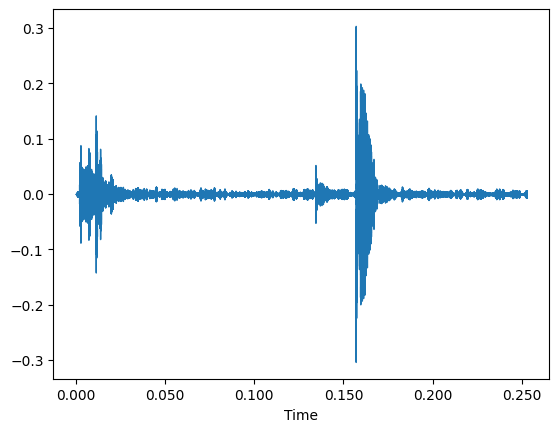

In [4]:
drop, _ = librosa.load(path+'water_drop.wav', sr=sr)
librosa.display.waveshow(drop, sr=sr)
ipd.display(ipd.Audio(drop, rate=sr))

# Q4

### Magnitude Spectra

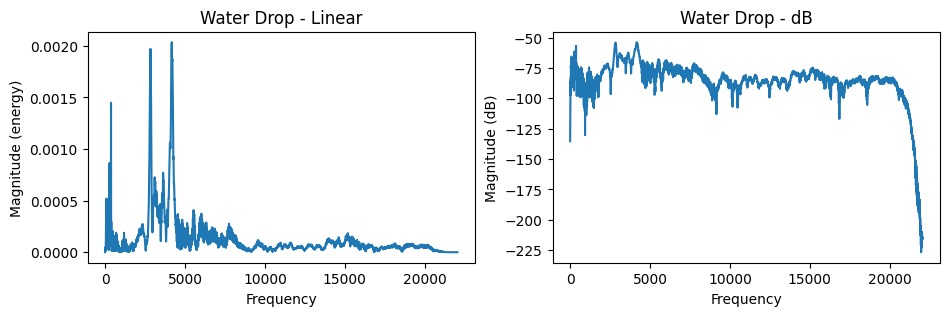

In [5]:
fig, axs = plt.subplots(1,2, figsize=(11,3))

axs[0].magnitude_spectrum(drop, Fs=sr)
axs[1].magnitude_spectrum(drop, Fs=sr, scale='dB')

axs[0].set_title('Water Drop - Linear')
axs[1].set_title('Water Drop - dB')

plt.show()

### Magnitude Spectrograms

Text(0.5, 1.0, 'Water Drop - dB')

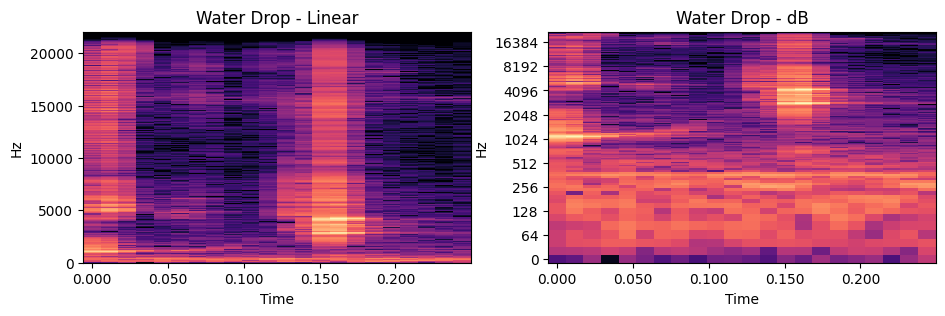

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11,3))

D = librosa.amplitude_to_db(np.abs(librosa.stft(drop)), ref=np.max)

librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax[0])
ax[0].set_title('Water Drop - Linear')

librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set_title('Water Drop - dB')

I couldn't turn the fan off in the room I recorded, hence the noise in these plots. But you should see the water's actual pitches around 1024 Hz, then up to between 2048 and 4096 Hz.

# Q5

In [16]:
def bubble(radius=5.0, xi=0.1, t=1, sr=44100):
  """
  radius - in mm
  xi - damping parameterization factor
  sr - sample rate
  t - clip length
  """

  freq = 3 / radius * 1000
  # d = 0.13 / radius + 0.0072 / radius ** 1.5
  d = 0.043 * freq + 0.0014 * freq ** 1.5
  # a = radius ** 1.5

  # x = np.linspace(0, t, t * sr)
  # sig = np.sin(2 * np.pi * freq * x)

  fmax = freq * (1 + xi * d)
  sig = librosa.chirp(fmin=freq, fmax=fmax, sr=sr, length=sr)
  
  damping = np.linspace(0, t, t * sr)
  for i in range(damping.size):
    damping[i] = np.exp(-d * i / sr)

  return sig * damping

In [38]:
# radius in mm
sig = bubble(radius=10)
ipd.display(ipd.Audio(sig, rate=sr))

# Q6

In [41]:
radii = [10, 7, 4, 2, 1, 0.5, 0.3]
xis = [0, 0.05, 0.1]

for r in radii:
  for xi in xis:
    print(f'Radius: {r}\tXi: {xi}')
    sig = bubble(radius=r, xi=xi)
    ipd.display(ipd.Audio(sig, rate=sr))

Radius: 10	Xi: 0


Radius: 10	Xi: 0.05


Radius: 10	Xi: 0.1


Radius: 7	Xi: 0


Radius: 7	Xi: 0.05


Radius: 7	Xi: 0.1


Radius: 4	Xi: 0


Radius: 4	Xi: 0.05


Radius: 4	Xi: 0.1


Radius: 2	Xi: 0


Radius: 2	Xi: 0.05


Radius: 2	Xi: 0.1


Radius: 1	Xi: 0


Radius: 1	Xi: 0.05


Radius: 1	Xi: 0.1


Radius: 0.5	Xi: 0


Radius: 0.5	Xi: 0.05


Radius: 0.5	Xi: 0.1


Radius: 0.3	Xi: 0


Radius: 0.3	Xi: 0.05


Radius: 0.3	Xi: 0.1


# Q7

In [125]:
# number of bubbles
N = 50

# radius bounds (mm)
# maximum range: [0.2, 50]
r_min = 0.5
r_max = 50

radii = [r_min * (r_max / r_min) ** ((k - 1) / (N - 1)) for k in range(50)]
radii = np.array(radii)
np.random.shuffle(radii)

# average number of bubbles per second
avg_bps = 100

# fraction of bubbles with rising pitch
r_rising_pitch = 0.1
has_rising_pitch = np.zeros(math.floor(N * r_rising_pitch))
n_ones = N - has_rising_pitch.size
has_rising_pitch = np.append(has_rising_pitch, np.ones(n_ones))
np.random.shuffle(has_rising_pitch)

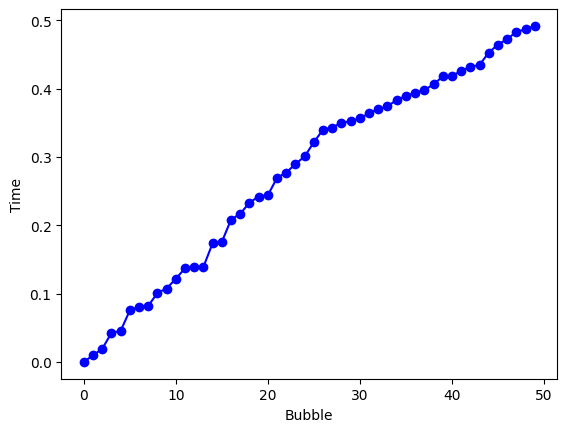

In [126]:
event_time = 0
x = []
bubble_times = []
inter_times = []

for i in range(N):
  x.append(i)

  p = random.random()
  inter_event_time = -math.log(1.0 - p) / avg_bps
  inter_times.append(inter_event_time)

  event_time += inter_event_time
  bubble_times.append(event_time)

fig = plt.figure()
plot, = plt.plot(x, bubble_times, 'bo-')
plt.xlabel('Bubble')
plt.ylabel('Time')
plt.show()

# Q8

In [127]:
pad_size = 0
l = math.ceil(np.sum(inter_times) * sr + sr)
sig = np.zeros(l)

for i in range(N):
  xi = 0.1 if has_rising_pitch[i] == 1 else 0
  bub = bubble(radius=radii[i], xi=xi)

  pad = np.zeros(pad_size)
  next = np.append(pad, bub)
  next = np.append(next, np.zeros(l-next.size))

  pad_size += int(inter_times[i] * sr)

  sig += next

In [128]:
ipd.display(ipd.Audio(sig, rate=sr))